In [17]:
import numpy as np


#replay buffer class

class ReplayBuffer:
    def __init__(self, mem_size, input_shape, num_actions):
        self.mem_size = mem_size
        self.mem_cntr =  0
        self.state_memory = np.zeros((mem_size, input_shape))
        self.new_state_memory = np.zeros((mem_size, input_shape))
        self.action_memory = np.zeros((mem_size, num_actions))
        self.reward_memory = np.zeros((mem_size))
        self.terminal_memory = np.zeros(mem_size, dtype = np.bool)
    
    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr%self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.new_state_memory[index] = new_state
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1
    
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size, replace = False)
        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, states_, actions, rewards, dones



In [18]:
import os
import tensorflow as tf
from tensorflow import keras 
from keras.layers import Dense


#critic network

class Critic(keras.Model):
    def __init__(self,  name, hl1_dims, hl2_dims):
        super(Critic, self).__init__()
        self.hl1_dims = hl1_dims
        self.hl2_dims = hl2_dims
        self._name = name

        self.hl1 = Dense(self.hl1_dims, activation = 'relu')
        self.hl2 = Dense(self.hl2_dims, activation = 'relu')
        self.q = Dense(1, activation = None)

    def call(self, state, action, training=None):
        
        action_value = self.hl1(tf.concat([state, action], axis = 1))
        action_value = self.hl2(action_value)
        q = self.q(action_value)

        return q


#actor network


class Actor(keras.Model):
    def __init__(self, name, hl1_dims, hl2_dims, n_actions):
        super(Actor, self).__init__()
        self.hl1_dims = hl1_dims
        self.hl2_dims = hl2_dims
        self._name = name
        self.n_actions = n_actions

        self.hl1 = Dense(self.hl1_dims, activation = 'relu')
        self.hl2 = Dense(self.hl2_dims, activation = 'relu')
        self.action = Dense(n_actions, activation = 'tanh')
    
    def call(self, state, training = None):
        a1 = self.hl1(state)
        a2 = self.hl2(a1)
        ac = self.action(a2)

        return ac






In [19]:

from tensorflow.keras.optimizers import Adam

#DDPG agent class

class Agent:
    def __init__(self, input_dims, n_actions, alpha = 0.001, beta = 0.002, gama = 0.99, max_size = 1000000, tau = 0.005, hl1_dims = 400, hl2_dims = 300,env = None, batch_size = 64):
        self.gama = gama 
        self.tau = tau
        self.alpha = alpha
        self.beta = beta
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.buffer = ReplayBuffer(max_size, input_dims, n_actions)
        self.max_action = 1;
        self.min_action = -1;
       
        self.actor = Actor(name='actor', hl1_dims=hl1_dims, hl2_dims=hl2_dims, n_actions=n_actions)
        
        self.target_actor = Actor(name='target_actor', hl1_dims=hl1_dims, hl2_dims=hl2_dims, n_actions=n_actions)
        
        self.critic = Critic(name='critic', hl1_dims=hl1_dims, hl2_dims=hl2_dims)
        
        self.target_critic = Critic(name='target_critic', hl1_dims=hl1_dims, hl2_dims=hl2_dims)

        
        self.actor.compile(optimizer = Adam(learning_rate = alpha))
        self.target_actor.compile(optimizer = Adam(learning_rate = alpha))
        self.critic.compile(optimizer = Adam(learning_rate = beta))
        self.target_critic.compile(optimizer = Adam(learning_rate = beta))
        self.critic_grad = Adam(learning_rate = alpha)


        self.update(tau = 1)

    #applying soft updates on target actor and target critic
    
    def update(self, tau = None):
        if tau is None:
            tau = self.tau
        
        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight*tau + targets[i]*(1-tau))
        
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight*tau + targets[i]*(1-tau))
        
        self.target_critic.set_weights(weights)
    
    def remember(self, state, state_, action, reward, done):
        self.buffer.store_transition(state=state, action=action, reward=reward, new_state=state_, done=done)
    

    
    def choose_action(self, state, evaluate = False):

        input_tensor = tf.convert_to_tensor(state)
        tf_state = tf.expand_dims(input_tensor, 0)
        actions = self.actor(tf_state)
        actions += tf.random.normal(shape = [self.n_actions], mean = 0.0, stddev = 0.1)
        actions = tf.clip_by_value(actions, self.min_action, self.max_action)
        return actions[0]


    #applying graidents on the actor and critic network according to their loss fucntions
    
    def learn(self):
        if(self.buffer.mem_cntr<self.batch_size):
            return
        
        states, states_, actions, rewards, dones = self.buffer.sample_buffer(self.batch_size)

        state = tf.convert_to_tensor(states, dtype = tf.float32)
        state_ = tf.convert_to_tensor(states_, dtype = tf.float32)
        action = tf.convert_to_tensor(actions, dtype = tf.float32)
        reward = tf.convert_to_tensor(rewards, dtype = tf.float32)

        with tf.GradientTape() as tape:
            target_actions = self.target_actor(state_)
            delta = tf.squeeze(self.target_critic(
                state_, target_actions), 1)
            y = reward + self.gama * delta*(1-dones)
            critic_value = tf.squeeze(self.critic(state, action), 1)
            critic_loss = keras.losses.MSE(y, critic_value)

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(
            zip(critic_grad, self.critic.trainable_variables)

        )

        with tf.GradientTape() as tape:
            actions = self.actor(state)
            cv = -self.critic(state, actions)
            actor_loss = tf.math.reduce_mean(cv)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )

        self.update(self.tau)
 









        


In [42]:

import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import gym

import matplotlib.pyplot as plt


from sklearn.cluster import KMeans

def create_UE_cluster(x1, y1, x2, y2):
  X = []
  Y = []
  while(len(X)<10):
    cord_x = round(random.uniform(x1,x2),2)
    if(cord_x not in X):
      X.append(cord_x)
  while(len(Y)<10):
    cord_y = round(random.uniform(y1,y2),2)
    if(cord_y not in Y):
      Y.append(cord_y)
  k = []
  i = 0
  while(i<10):
      k.append([X[i],Y[i]])
      i += 1
        
  return k

ue_cluster_1 = create_UE_cluster(400, 450, 470, 520)


#custom environment


class UAVENV():
  def __init__(self, c1):
    self.cluster1 = c1
    self.cluster = self.clustercentre(c1)


  def step(self, action):
    #action = action[0]
    d = (action[0]/2+0.5)*100
    theta = (action[1]/2+0.5)*299
    dummy = self.state
    dummy[0] += d*math.cos(theta)
    dummy[1] += d*math.sin(theta)

    if(dummy[0]<=600 and dummy[1]<=600):
      self.state = dummy
    
    dis = self.dist(self.state, self.cluster)
    done = False
    if(dis<=50):
      done = True

    return self.state, -1*dis, done
    




    


  def dist(self, pos1, pos2):
    return ((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)**0.5

  def clustercentre(self, c):
   x = np.array(c)
   km = KMeans(n_clusters=1).fit(x)
   return km.cluster_centers_[0]


  

  def reset(self):
    
    
    
    u1 = np.array([200, 200], dtype = np.float32)
    self.state = u1
    return self.state
    


  
  def render(self):
    fig, ax = plt.subplots()
    X = []
    Y = []
    for i in range(0,10):
        X.append(self.cluster1[i][0])
        Y.append(self.cluster1[i][1])

    ax.set_xlim([0,600])
    ax.set_ylim([0,600])
    ax.plot(np.array(X),np.array(Y),'ro')
    uavcord1 = (self.state[0],self.state[1])
    ax.scatter(uavcord1[0], uavcord1[1], marker = "X", s= 200)
    plt.show()


<ipython-input-17-a009ebd464a7>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(mem_size, dtype = np.bool)


episode 0 score: -48708.51859542928
episode 1 score: -41402.174742074836
episode 2 score: -39074.47793885662
episode 3 score: -38080.719799444705
episode 4 score: -36698.73900949861
episode 5 score: -36023.503456419036
episode 6 score: -35623.446737854676
episode 7 score: -35501.62717457302
episode 8 score: -35110.42777899654
episode 9 score: -34837.17217569215
episode 10 score: -34732.190535552865
episode 11 score: -34602.6110396331
episode 12 score: -34334.53420954136
episode 13 score: -34268.18640415374
episode 14 score: -34251.90258034594
episode 15 score: -34148.233627958965
episode 16 score: -34124.38090633832
episode 17 score: -34003.898023402595
episode 18 score: -33927.22547443415
episode 19 score: -33928.18208336678
episode 20 score: -34000.50737719675
episode 21 score: -34020.161095591415
episode 22 score: -33973.65944537427
episode 23 score: -33895.90232255897
episode 24 score: -33957.773077930084
episode 25 score: -33886.57362666566
episode 26 score: -33868.077083010394
ep

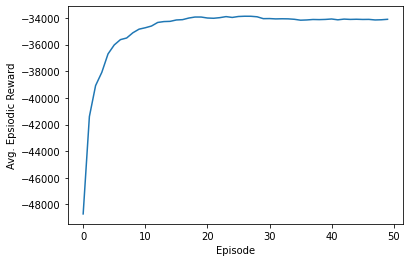

In [43]:
import gym


if __name__ == '__main__':
    env = UAVENV(ue_cluster_1)
    agent = Agent(input_dims=2, n_actions=2, env = env)

    score_history = []
    avgscore = []
    
    
    for i in range(50):
        obs = env.reset()
        done = False
        score = 0
        t = 0
        while (not done and t<100):
            action = agent.choose_action(obs)
            obs_, reward, done = env.step(action)
            score += reward
            agent.remember(obs, obs_, action, reward, done)
            agent.learn()
            t += 1
            obs = obs_
        
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        avgscore.append(avg_score)


        print('episode', i, 'score:', avg_score)
        
  

    plt.plot(avgscore)
    plt.xlabel("Episode")
    plt.ylabel("Avg. Epsiodic Reward")
    plt.show()






